# NR Classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import random as rd
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as tud
# from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import CustomDataset as cd
import Net

### Loading Data

First, I'm going to try to distinguish between Carbon 130keV and Flourine 170keV.

In [2]:
C130_dat, F170_dat = np.load('data/C_130keV.npy'), np.load('data/F_170keV.npy')

In [3]:
sum_list = []
for i in range(len(C130_dat)):
    sum_list.append(np.sum(C130_dat[i]))
    sum_list.append(np.sum(F170_dat[i]))

In [4]:
np.shape(sum_list)

(10000,)

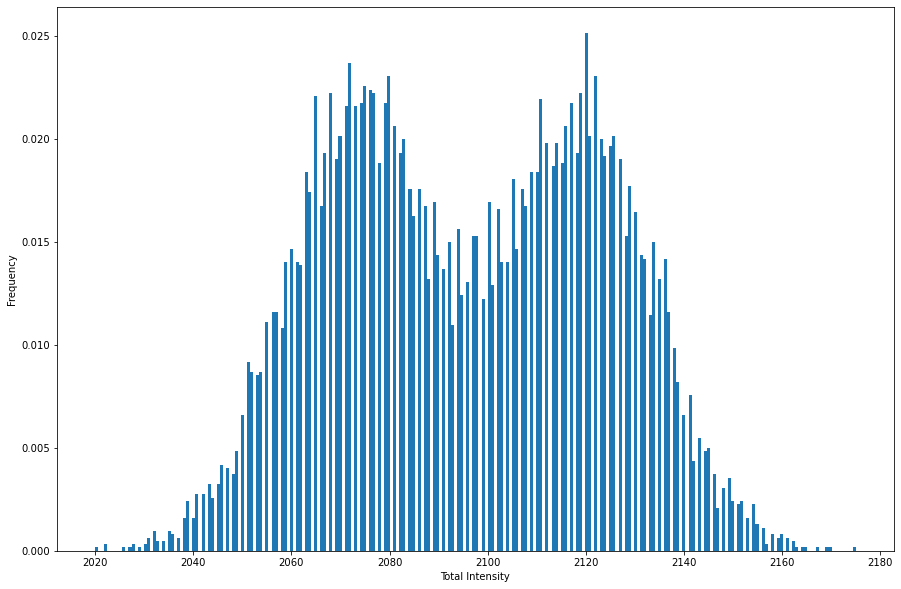

In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.figure(figsize=(15,10))
plt.hist(sum_list, density=True, bins=250)  # density=False would make counts
plt.ylabel('Frequency')
plt.xlabel('Total Intensity')
plt.savefig('intensity_hist.png');

In [6]:
np.sum(C130_dat[1])

2068.0

Now I'm going to put them all in one file and shuffle.

In [7]:
C130_dat.shape

(5000, 97, 97)

In [8]:
F170_dat.shape

(5000, 97, 97)

For a learning algorithm, it will be necesarry to have an input (X data) containing a number of $97\times97$ matrices for each energy. The output will be a label, either Carbon or Flourine. The model will compare its output with the actual labels and adjust accordingly to minimise loss. 

In order to quantify each label, the common 'one-hot encoding' method will be used. C elements will have the label `[1, 0]` and F will be `[0, 1]`. Tuples of this form will be the ground truth labels and the model output. I will have to ensure that the model outputs an array of shape `[2]`.

In [9]:
data, labels = [],[]

for i in range(len(C130_dat)):
    data.append(C130_dat[i])
    labels.append([1,0])

for i in range(len(F170_dat)):
    data.append(F170_dat[i])
    labels.append([0,1])

In [10]:
print(np.shape(data))
print(np.shape(labels))

(10000, 97, 97)
(10000, 2)


### Defining Model Training Functions

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [12]:
xtrain_tensor = torch.from_numpy(np.array(X_train)) #converts numpy array to torch tensor
xtrain_sqz = xtrain_tensor.unsqueeze(1) #adds new dimension along axis 1
print(xtrain_sqz.shape)


ytrain_tensor = torch.from_numpy(np.array(y_train))
ytrain_sqz = ytrain_tensor.unsqueeze(1)
print(ytrain_sqz.shape)

torch.Size([8000, 1, 97, 97])
torch.Size([8000, 1, 2])


In [13]:
xtest_tensor = torch.from_numpy(np.array(X_test)) #converts numpy array to torch tensor
xtest_sqz = xtest_tensor.unsqueeze(1) #adds new dimension along axis 1
print(xtest_sqz.shape)

ytest_tensor = torch.from_numpy(np.array(y_test))
ytest_sqz = ytest_tensor.unsqueeze(1)
print(ytest_sqz.shape)

torch.Size([2000, 1, 97, 97])
torch.Size([2000, 1, 2])


In [14]:
train_data = cd.CustomDataset(xtrain_sqz.float(), ytrain_sqz.float())
test_data = cd.CustomDataset(xtest_sqz.float(), ytest_sqz.float())

#defining dataloader class
train_loader = tud.DataLoader(dataset=train_data, batch_size=50, shuffle=True)
train_loader_iter = iter(train_loader)

#same as above but for test data
test_loader = tud.DataLoader(dataset=test_data, batch_size=50, shuffle=True)
test_loader_iter = iter(test_loader)

### Train/Test Functions

In [15]:
# def train(model, device, train_loader, optimizer, epoch, batch_size = 50):
#     model.train()
#     #loop run over data output by loader to train model
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data) #applies model to data
#         # print(target.shape)
#         target = target.squeeze(1) #removes dimension from target
#         # print(target.shape)
#         # print(output)
#         # print(target.shape)
#         loss = nn.CrossEntropyLoss()(output, target[:,1].long()) #calculates cross entropy loss
    
# #         loss = nn.CrossEntropyLoss()(output, target.long())
#         # print(loss)
#         model.zero_grad()
#         loss.backward()
#         optimizer.step() #new step in optimisation of loss
#         #printing output of each batch for loss observation while model is training
#         if batch_idx % batch_size == 0:
#             print(
#                 'Train Epoch: {} [{}/{} ({}%)]\tLoss: {}'.format(
#                     epoch, batch_idx * len(data), len(train_loader.dataset), \
#                     round(100 * batch_idx / len(train_loader),0), round(loss.item(),5)
#                 )
#             )

In [16]:
# def test(model, device, test_loader):
#     model.eval()
#     #initialisting parameters and empty lists
#     test_loss = 0
#     correct = 0
#     probs_pred = []
#     labels_actual = []
#     labels_pred = []
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             target=target.squeeze(1)
#             # print(output.shape)
#             test_loss += nn.CrossEntropyLoss()(output, target[:,1].long()).item()
#             # print(output)
# #             test_loss += nn.CrossEntropyLoss()(output, target.long()).item()

#             # pred = output.max(1, keepdim=True)[1] #finds index of maximum in output vector as described below

#             pred = output.max(1, keepdim=False)[1]#torch.round(output)

#             # print(output)
#             # pred_onehot = F.one_hot(pred).squeeze(1) #converts into one-hot predicted label 
#             # print(pred_onehot)
#             # print(test_loss)
#             # pred_bool = torch.eq(pred_onehot,target) #finds values where predicted equals target
#             pred_bool = torch.eq(pred,target)
#             # print(pred_bool)
#             # correct += int((pred_bool.sum().item())/2) #sums number of correct values
#             correct += pred_bool.sum().item()
#             #adds predicted labels, targets and probabilities to lists for later use
#             labels_actual.append(target.cpu().numpy())
#             probs_pred.append(output.cpu().numpy())
#             # labels_pred.append(pred_onehot.cpu().numpy())

#     #printing accuracy and loss after each epoch for analysis
#     test_loss /= len(test_loader.dataset)
#     print(
#         '\nTest set: Average loss: {}, Accuracy: {}/{} ({}%)\n'.format(
#               round(test_loss,4), correct, len(test_loader.dataset), \
#             round(100 * correct / len(test_loader.dataset),0)
#             )
#           )
  
#     return(labels_actual,probs_pred,labels_pred)

In [17]:
batch_size=20

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    #loop run over data output by loader to train model
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data) #applies model to data
        target = target.squeeze(1) #removes dimension from target
        loss = nn.CrossEntropyLoss()(output, target) #calculates cross entropy loss
        loss.backward()
        optimizer.step() #new step in optimisation of loss
        #printing output of each batch for loss observation while model is training
        if batch_idx % batch_size == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100 * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    #initialisting parameters and empty lists
    test_loss = 0
    correct = 0
    probs_pred = []
    labels_actual = []
    labels_pred = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            target=target.squeeze(1)
            test_loss += nn.CrossEntropyLoss()(output, target).item()
        
            pred = output.max(1, keepdim=True)[1] #finds index of maximum in output vector as described below
            pred_onehot = F.one_hot(pred).squeeze(1) #converts into one-hot predicted label 
            pred_bool = torch.eq(pred_onehot,target) #finds values where predicted equals target
            correct += int((pred_bool.sum().item())/2) #sums number of correct values
            #adds predicted labels, targets and probabilities to lists for later use
            
            labels_actual.append(target.cpu().numpy())
            probs_pred.append(output.cpu().numpy())
            labels_pred.append(pred_onehot.cpu().numpy())
 
    #printing accuracy and loss after each epoch for analysis
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100 * correct / len(test_loader.dataset)))
    
    return(labels_actual,probs_pred,labels_pred)

In [18]:
device = torch.device('cuda')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 5, kernel_size=(5,5)),
            nn.MaxPool2d(kernel_size=(3,3)),
            nn.ReLU(),
            nn.Conv2d(5, 10, kernel_size=(5,5)),
            nn.MaxPool2d(kernel_size=(3,3)),
            nn.ReLU(),
        )
            
        self.fc_layers = nn.Sequential(
            nn.Linear(810, 80),
            nn.ReLU(),
            nn.Linear(80,2),
            # nn.Softmax(dim=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 810) #flattens as described below
#         x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [19]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [20]:
#outputting variables from initial model
initial_model = model
print(model)
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

Net(
  (conv_layers): Sequential(
    (0): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=810, out_features=80, bias=True)
    (1): ReLU()
    (2): Linear(in_features=80, out_features=2, bias=True)
    (3): Sigmoid()
  )
)


(66432, [125, 5, 1250, 10, 64800, 80, 160, 2])

In [21]:
num_epochs = 7 #setting number of epochs for CNN

#running loop training and testing over previously specified number of epochs
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    act,pred,pred_labs = test(model, device, test_loader)

Train Epoch: 1 [0/8000 (0%)]	Loss: 0.699622
Train Epoch: 1 [1000/8000 (12%)]	Loss: 0.707991
Train Epoch: 1 [2000/8000 (25%)]	Loss: 0.692986
Train Epoch: 1 [3000/8000 (38%)]	Loss: 0.694716
Train Epoch: 1 [4000/8000 (50%)]	Loss: 0.677213
Train Epoch: 1 [5000/8000 (62%)]	Loss: 0.705140
Train Epoch: 1 [6000/8000 (75%)]	Loss: 0.710313
Train Epoch: 1 [7000/8000 (88%)]	Loss: 0.720904

Test set: Average loss: 0.0134, Accuracy: 1184/2000 (59%)

Train Epoch: 2 [0/8000 (0%)]	Loss: 0.658818
Train Epoch: 2 [1000/8000 (12%)]	Loss: 0.659533
Train Epoch: 2 [2000/8000 (25%)]	Loss: 0.626134
Train Epoch: 2 [3000/8000 (38%)]	Loss: 0.667966
Train Epoch: 2 [4000/8000 (50%)]	Loss: 0.641279
Train Epoch: 2 [5000/8000 (62%)]	Loss: 0.637070
Train Epoch: 2 [6000/8000 (75%)]	Loss: 0.625189
Train Epoch: 2 [7000/8000 (88%)]	Loss: 0.733540

Test set: Average loss: 0.0132, Accuracy: 1220/2000 (61%)

Train Epoch: 3 [0/8000 (0%)]	Loss: 0.660975
Train Epoch: 3 [1000/8000 (12%)]	Loss: 0.681730
Train Epoch: 3 [2000/8000 (2

### Different Networks

In [22]:
device = torch.device('cuda')

#defining CNN class, see description below
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 5, kernel_size=(6,6)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU(),
            nn.Conv2d(5, 10, kernel_size=(5,5)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU(),
            nn.Conv2d(10, 50, kernel_size=(6,6)),
            nn.MaxPool2d(kernel_size=(2,2)),
            nn.ReLU(),
        )
            
        self.fc_layers = nn.Sequential(
            nn.Linear(3200,1000),
            nn.ReLU(),
            nn.Linear(1000,300),
            nn.ReLU(),
            nn.Linear(300,80),
            nn.ReLU(),
            nn.Linear(80,2),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 3200) #flattens as described below
#         x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [23]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [24]:
#outputting variables from initial model
initial_model = model
numel_list = [p.numel() for p in model.parameters()]

In [25]:
num_epochs = 15 #setting number of epochs for CNN

#running loop training and testing over previously specified number of epochs
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    act,pred,pred_labs = test(model, device, test_loader)

Train Epoch: 1 [0/8000 (0%)]	Loss: 0.694084
Train Epoch: 1 [1000/8000 (12%)]	Loss: 0.675140
Train Epoch: 1 [2000/8000 (25%)]	Loss: 0.695014
Train Epoch: 1 [3000/8000 (38%)]	Loss: 0.696487
Train Epoch: 1 [4000/8000 (50%)]	Loss: 0.680989
Train Epoch: 1 [5000/8000 (62%)]	Loss: 0.708107
Train Epoch: 1 [6000/8000 (75%)]	Loss: 0.671616
Train Epoch: 1 [7000/8000 (88%)]	Loss: 0.697973

Test set: Average loss: 0.0136, Accuracy: 1138/2000 (57%)

Train Epoch: 2 [0/8000 (0%)]	Loss: 0.688464
Train Epoch: 2 [1000/8000 (12%)]	Loss: 0.627687
Train Epoch: 2 [2000/8000 (25%)]	Loss: 0.647717
Train Epoch: 2 [3000/8000 (38%)]	Loss: 0.677779
Train Epoch: 2 [4000/8000 (50%)]	Loss: 0.694466
Train Epoch: 2 [5000/8000 (62%)]	Loss: 0.725396
Train Epoch: 2 [6000/8000 (75%)]	Loss: 0.682154
Train Epoch: 2 [7000/8000 (88%)]	Loss: 0.691198

Test set: Average loss: 0.0135, Accuracy: 1158/2000 (58%)

Train Epoch: 3 [0/8000 (0%)]	Loss: 0.648450
Train Epoch: 3 [1000/8000 (12%)]	Loss: 0.667011
Train Epoch: 3 [2000/8000 (2

### On 10,000 data points each

In [27]:
C130_10k_dat, F170_10k_dat = np.load('data/C_130keV_10000.npy'), np.load('data/F_170keV_10000.npy')

In [28]:
data, labels = [],[]

for i in range(len(C130_dat)):
    data.append(C130_dat[i])
    labels.append([1,0])

for i in range(len(F170_dat)):
    data.append(F170_dat[i])
    labels.append([0,1])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(im_dat, el_labs, test_size=0.2, random_state=42)

In [30]:
xtrain_tensor = torch.from_numpy(np.array(X_train)) #converts numpy array to torch tensor
xtrain_sqz = xtrain_tensor.unsqueeze(1) #adds new dimension along axis 1
print(xtrain_sqz.shape)

ytrain_tensor = torch.from_numpy(np.array(y_train))
ytrain_sqz = ytrain_tensor.unsqueeze(1)
print(ytrain_sqz.shape)

xtest_tensor = torch.from_numpy(np.array(X_test)) #converts numpy array to torch tensor
xtest_sqz = xtest_tensor.unsqueeze(1) #adds new dimension along axis 1
print(xtest_sqz.shape)

ytest_tensor = torch.from_numpy(np.array(y_test))
ytest_sqz = ytest_tensor.unsqueeze(1)
print(ytest_sqz.shape)

train_data = cd.CustomDataset(xtrain_sqz.float(), ytrain_sqz.float())
test_data = cd.CustomDataset(xtest_sqz.float(), ytest_sqz.float())

#defining dataloader class
train_loader = tud.DataLoader(dataset=train_data, batch_size=50, shuffle=True)
train_loader_iter = iter(train_loader)

#same as above but for test data
test_loader = tud.DataLoader(dataset=test_data, batch_size=50, shuffle=True)
test_loader_iter = iter(test_loader)

torch.Size([116000, 1, 97, 97])
torch.Size([116000, 1, 2])
torch.Size([29000, 1, 97, 97])
torch.Size([29000, 1, 2])


In [31]:
num_epochs = 5 #setting number of epochs for CNN
batch_size=1000

#running loop training and testing over previously specified number of epochs
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    act,pred,pred_labs = test(model, device, test_loader)

Train Epoch: 1 [0/116000 (0%)]	Loss: 0.787554
Train Epoch: 1 [50000/116000 (43%)]	Loss: 0.581452
Train Epoch: 1 [100000/116000 (86%)]	Loss: 0.563212

Test set: Average loss: 0.0108, Accuracy: 21842/29000 (75%)

Train Epoch: 2 [0/116000 (0%)]	Loss: 0.590447
Train Epoch: 2 [50000/116000 (43%)]	Loss: 0.473424
Train Epoch: 2 [100000/116000 (86%)]	Loss: 0.527991

Test set: Average loss: 0.0103, Accuracy: 22546/29000 (78%)

Train Epoch: 3 [0/116000 (0%)]	Loss: 0.472085
Train Epoch: 3 [50000/116000 (43%)]	Loss: 0.435479
Train Epoch: 3 [100000/116000 (86%)]	Loss: 0.450382

Test set: Average loss: 0.0102, Accuracy: 22860/29000 (79%)

Train Epoch: 4 [0/116000 (0%)]	Loss: 0.437694
Train Epoch: 4 [50000/116000 (43%)]	Loss: 0.550174
Train Epoch: 4 [100000/116000 (86%)]	Loss: 0.568644

Test set: Average loss: 0.0101, Accuracy: 22921/29000 (79%)

Train Epoch: 5 [0/116000 (0%)]	Loss: 0.498107
Train Epoch: 5 [50000/116000 (43%)]	Loss: 0.461640
Train Epoch: 5 [100000/116000 (86%)]	Loss: 0.473634

Test s

### Now on all the data

In [26]:
im_dat, el_labs, en_labs = [],[],[]
for i in np.arange(50,196,5):
    C_dat = np.load('data/C_'+str(i)+'keV.npy')
    for n in range(np.shape(C_dat)[0]):
        im_dat.append(C_dat[n]),el_labs.append([1,0]),en_labs.append(i)
    F_dat = np.load('data/F_'+str(i)+'keV.npy')
    for n in range(np.shape(F_dat)[0]):
        im_dat.append(F_dat[n]),el_labs.append([0,1]),en_labs.append(i)

KeyboardInterrupt: 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(im_dat, el_labs, test_size=0.2, random_state=42)

In [ ]:
xtrain_tensor = torch.from_numpy(np.array(X_train)) #converts numpy array to torch tensor
xtrain_sqz = xtrain_tensor.unsqueeze(1) #adds new dimension along axis 1
print(xtrain_sqz.shape)

ytrain_tensor = torch.from_numpy(np.array(y_train))
ytrain_sqz = ytrain_tensor.unsqueeze(1)
print(ytrain_sqz.shape)

xtest_tensor = torch.from_numpy(np.array(X_test)) #converts numpy array to torch tensor
xtest_sqz = xtest_tensor.unsqueeze(1) #adds new dimension along axis 1
print(xtest_sqz.shape)

ytest_tensor = torch.from_numpy(np.array(y_test))
ytest_sqz = ytest_tensor.unsqueeze(1)
print(ytest_sqz.shape)

train_data = cd.CustomDataset(xtrain_sqz.float(), ytrain_sqz.float())
test_data = cd.CustomDataset(xtest_sqz.float(), ytest_sqz.float())

#defining dataloader class
train_loader = tud.DataLoader(dataset=train_data, batch_size=50, shuffle=True)
train_loader_iter = iter(train_loader)

#same as above but for test data
test_loader = tud.DataLoader(dataset=test_data, batch_size=50, shuffle=True)
test_loader_iter = iter(test_loader)

In [ ]:
num_epochs = 5 #setting number of epochs for CNN
batch_size=1000

#running loop training and testing over previously specified number of epochs
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    act,pred,pred_labs = test(model, device, test_loader)

I suspect the higher accuracies on this compared to on C130 vs F170 are due to the difference in recoil track length for the same energy towards the ends of the energy spectrum. At the ends of the spectrum it can distinguish them just by how long they are, rather than by their shape (which is what we want).

### On a smaller subset of data

In [ ]:
def dataprep(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    xtrain_tensor = torch.from_numpy(np.array(X_train)) #converts numpy array to torch tensor
    xtrain_sqz = xtrain_tensor.unsqueeze(1) #adds new dimension along axis 1
    print(xtrain_sqz.shape)

    ytrain_tensor = torch.from_numpy(np.array(y_train))
    ytrain_sqz = ytrain_tensor.unsqueeze(1)
    print(ytrain_sqz.shape)

    xtest_tensor = torch.from_numpy(np.array(X_test)) #converts numpy array to torch tensor
    xtest_sqz = xtest_tensor.unsqueeze(1) #adds new dimension along axis 1
    print(xtest_sqz.shape)

    ytest_tensor = torch.from_numpy(np.array(y_test))
    ytest_sqz = ytest_tensor.unsqueeze(1)
    print(ytest_sqz.shape)

    train_data = cd.CustomDataset(xtrain_sqz.float(), ytrain_sqz.float())
    test_data = cd.CustomDataset(xtest_sqz.float(), ytest_sqz.float())

    #defining dataloader class
    train_loader = tud.DataLoader(dataset=train_data, batch_size=50, shuffle=True)
    train_loader_iter = iter(train_loader)

    #same as above but for test data
    test_loader = tud.DataLoader(dataset=test_data, batch_size=50, shuffle=True)
    test_loader_iter = iter(test_loader)
    
    return train_loader, test_loader

In [ ]:
im_dat, el_labs, en_labs = [],[],[]
for i in np.arange(60,101,5):
    C_dat = np.load('data/C_'+str(i)+'keV.npy')
    for n in range(np.shape(C_dat)[0]):
        im_dat.append(C_dat[n]),el_labs.append([1,0]),en_labs.append(i)
    F_dat = np.load('data/F_'+str(i)+'keV.npy')
    for n in range(np.shape(F_dat)[0]):
        im_dat.append(F_dat[n]),el_labs.append([0,1]),en_labs.append(i)

In [ ]:
train_loader, test_loader = dataprep(im_dat,el_labs)

In [ ]:
num_epochs = 5 #setting number of epochs for CNN
batch_size=100

#running loop training and testing over previously specified number of epochs
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    act,pred,pred_labs = test(model, device, test_loader)

### Smaller subset of data

In [ ]:
im_dat, el_labs, en_labs = [],[],[]
for i in np.arange(85,101,5):
    C_dat = np.load('data/C_'+str(i)+'keV.npy')
    for n in range(np.shape(C_dat)[0]):
        im_dat.append(C_dat[n]),el_labs.append([1,0]),en_labs.append(i)
    F_dat = np.load('data/F_'+str(i)+'keV.npy')
    for n in range(np.shape(F_dat)[0]):
        im_dat.append(F_dat[n]),el_labs.append([0,1]),en_labs.append(i)

In [ ]:
train_loader, test_loader = dataprep(im_dat,el_labs)

In [ ]:
num_epochs = 5 #setting number of epochs for CNN
batch_size=100

#running loop training and testing over previously specified number of epochs
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    act,pred,pred_labs = test(model, device, test_loader)

This very high accuracy is only because the recoil tracks are much longer for Carbon.

I need more data.

### Trying more data with C130:F170 ratio

65:85, 130:170

In [ ]:
C65_dat, F85_dat = np.load('data/C_65keV.npy'), np.load('data/F_85keV.npy')

In [ ]:
data, labels = [],[]

for i in range(len(C130_dat)):
    data.append(C130_dat[i])
    labels.append([1,0])
    data.append(C65_dat[i])
    labels.append([1,0])

for i in range(len(F170_dat)):
    data.append(F170_dat[i])
    labels.append([0,1])
    data.append(F85_dat[i])
    labels.append([0,1])

In [ ]:
np.shape(data)

In [ ]:
train_loader, test_loader = dataprep(data,labels)

In [ ]:
num_epochs = 5 #setting number of epochs for CNN
batch_size=50

#running loop training and testing over previously specified number of epochs
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    act,pred,pred_labs = test(model, device, test_loader)

### Options for multi-class classifying

To eliminate confusion when reading:
- Multi-class classification is when there are more than one target labels, but each observation can only be one of those labels
- Multi-label classification is when there are more than one target labels, and each observation can be multiple labels at the same time (eg. assigning something multiple descriptors: ' A text might be about any of religion, politics, finance or education at the same time or none of these'
- Multi-output classification / multitask classification is when there are multiple categories of label and the observation must be one of both (eg. green and a pear, green and an apple)